# Customer Retention Analysis: Telco Churn Dataset
### Understanding customer behavior and identifying churn drivers for a telecommunications company

---

## Notebook 03: Exploratory Data Analysis
This notebook explores the key characteristics of the Telco Churn dataset through detailed exploratory data analysis (EDA). We examine distributions across customer demographics, service usage, contract types, and financial metrics, then analyze how these factors relate to customer churn and loyalty patterns.

---
## Exploratory Data Analysis: Table of Contents
- [3.0 Exploratory Data Analysis (EDA)](#30-exploratory-data-analysis)
    - [3.1 Customer Demographics](#31-customer-demographics)
    - [3.2 Service Features](#32-service-features)
    - [3.3 Account & Contract Features](#33-account--contract-features)
    - [3.4 Financial Metrics](#34-financial-metrics)
    - [3.5 Tenure & Loyalty](#35-tenure--loyalty-feature-synthesis)
    - [3.6 Summary](#36-summary)

In [1]:
# Import libraries
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load Data
ENCODED_DATA_PATH = Path('../data/encoded_telco_churn_data.csv')
READABLE_DATA_PATH = Path('../data/readable_telco_churn_data.csv')
df = pd.read_csv(ENCODED_DATA_PATH)
df_readable = pd.read_csv(READABLE_DATA_PATH)

## 3.0 Exploratory Data Analysis <a class="anchor" id="30-exploratory-data-analysis"></a>

Our goal is to predict `churn` using the datasets other features. Visualizing some of the more interesting features will allow us to understand the relationships between the data and identify promising features for future models.

In [3]:
# Set style theme for data visualizations
sns.set_theme(style='whitegrid', context='notebook', palette='colorblind')

# Set consistent fontsize and fontweight
fontsize = 14
fontweight = 'bold'


In [4]:
# Create countplot styling function
def styled_countplot(
    data, 
    x=None, 
    hue=None,
    ax=None,
    order=None,
    hue_order=None,
    stat=None,
    label_type=None
):
    """
    A helper function to create countplots with homogenized styling
    """
    # Create the countplot
    plot = sns.countplot(
        data=data, 
        x=x, 
        hue=hue,
        hue_order=hue_order,
        stat=stat,
        ax=ax, 
        order=order
    )

    # Set axis
    if ax is None:
        ax = plt.gca()
        
    # Set title, legend based on hue value
    if hue is not None:
        ax.set_title(f'{str.title(x).replace('_', ' ')} by {str.title(hue).replace('_', ' ')}' , fontsize=fontsize, fontweight=fontweight)
        ax.legend(data[hue].unique())
    else:
        ax.set_title(str.title(x).replace('_', ' '), fontsize=fontsize, fontweight=fontweight)

    # Set x and y labels
    ax.set_xlabel(str.replace(x, '_', ' ').title())
    ax.set_ylabel(stat.capitalize())

    # Set bar labels and label colors
    if label_type == 'center':
        for container in ax.containers:
            ax.bar_label(container, fmt='%.1f%%', label_type=label_type, fontsize=9, fontweight=fontweight, color='#EEEEEE')
            
    elif label_type == 'edge':
        for container in ax.containers:
            ax.bar_label(container, fmt='%.1f%%', label_type=label_type, fontsize=9, fontweight=fontweight, color='black')

    return plot

### 3.1 Customer Demographics <a class="anchor" id="31-customer-demographics"></a>

Exploring the characteristics of Telco customers is a solid place to start examining our dataset and understanding how different customer groups relate to churn likelihood.

**Key Demographic Features:**
- gender
- senior_citizen
- partner
- dependents

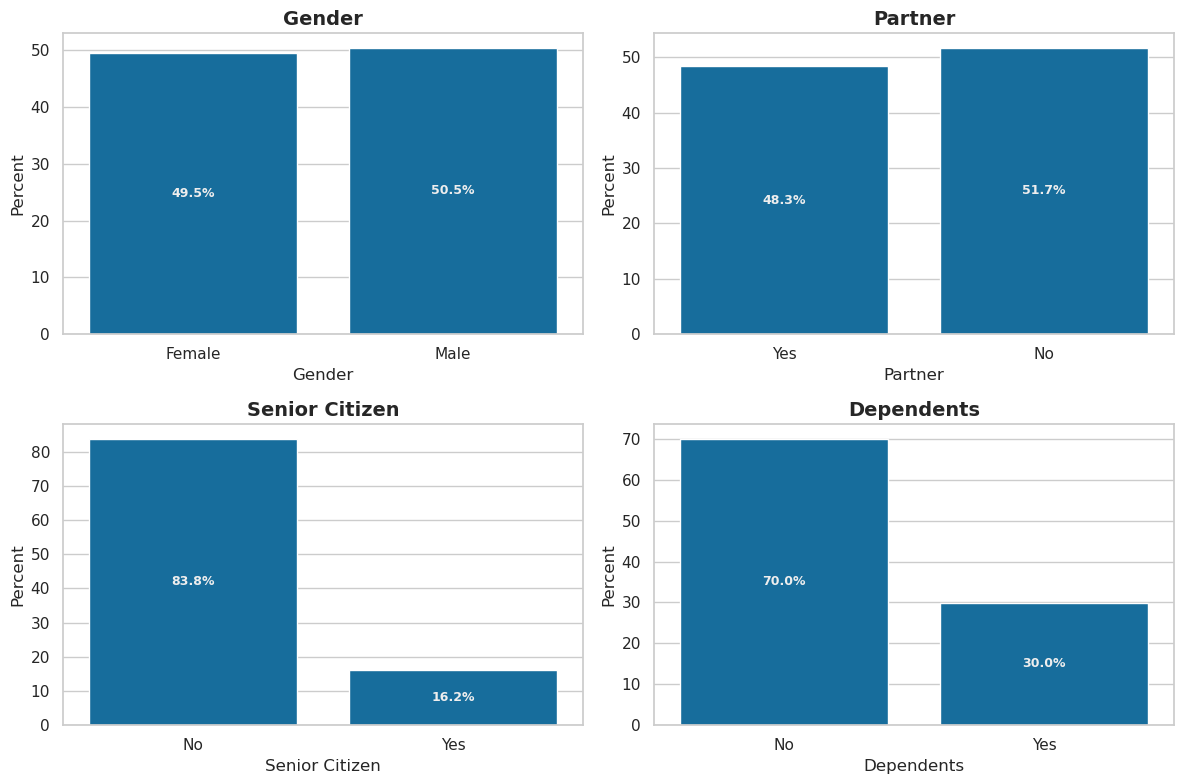

In [5]:
# Visualize churn by our key demographic features
fig, axes = plt.subplots(2, 2, figsize=(12, 8))


# Create plots with helper function
styled_countplot(data=df_readable, x='gender', ax=axes[0, 0], stat='percent', label_type='center')
styled_countplot(data=df_readable, x='senior_citizen', ax=axes[1, 0], stat='percent', label_type='center')
styled_countplot(data=df_readable, x='partner', ax=axes[0, 1], stat='percent', label_type='center')
styled_countplot(data=df_readable, x='dependents', ax=axes[1, 1], stat='percent', label_type='center')

plt.tight_layout() # Use tight layout to save space
plt.show()

**Observations:** There are slightly more single customers than those with partners. Only 16% of Telco customers are senior citizens. Exactly 30% of customers in this dataset have dependents. And, as previously established, customers are evenly split between sexes.

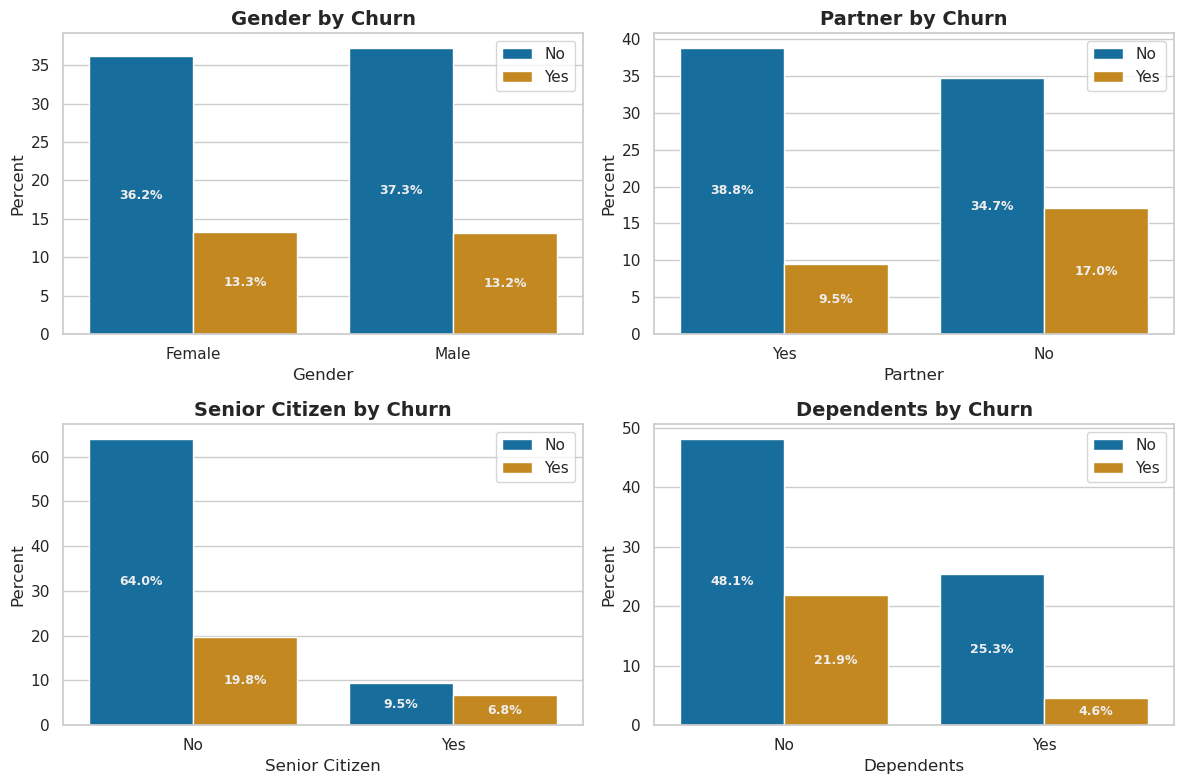

In [6]:
# Visualize churn by our key demographic features
fig, axes = plt.subplots(2, 2, figsize=(12, 8))


# Create plots with helper function
styled_countplot(data=df_readable, x='gender', hue='churn', ax=axes[0, 0], stat='percent', label_type='center')
styled_countplot(data=df_readable, x='senior_citizen', hue='churn', ax=axes[1, 0], stat='percent', label_type='center')
styled_countplot(data=df_readable, x='partner', hue='churn', ax=axes[0, 1], stat='percent', label_type='center')
styled_countplot(data=df_readable, x='dependents', hue='churn', ax=axes[1, 1], stat='percent', label_type='center')

plt.tight_layout() # Use tight layout to save space
plt.show()

**Observations:** Senior citizens are the most likely group to churn, but they also only accounted for approximately 16.3% of customers. Customers without partners and customers without dependents also significantly more likely to churn than those with partners or dependents. Gender appears to have no relationship to churn rate. However, this is just part of the picture and it not establish a causal relationship. There is overlap between these groups as well, so untangling how each quality corresponds to churn rate will be our next task.

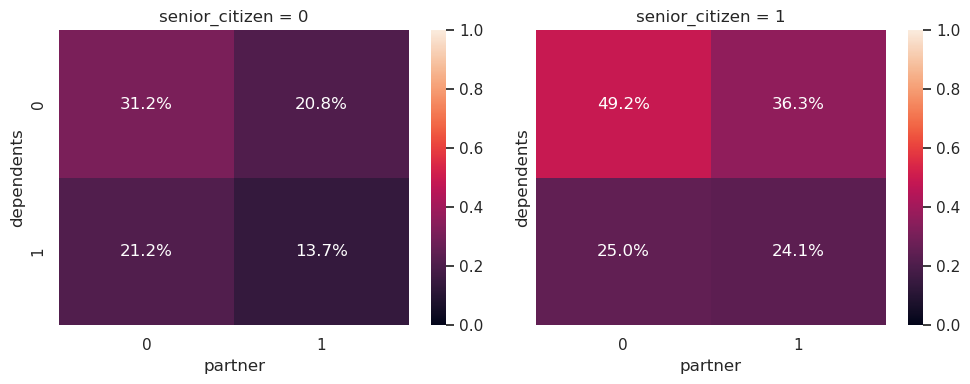

In [7]:
# Get average churn rate by demographic grpup
churn_rates = (
    df.groupby(['senior_citizen', 'partner', 'dependents'])['churn']
      .mean()
      .reset_index()
)

# Plot demographic groups by churn and senior citizen status 
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Enumerate over senior_citizen values to create a plot corresponding to each (0/1)
for i, val in enumerate(sorted(df['senior_citizen'].unique())):
    # Use pivot table to reorganize values
    pivot = churn_rates[churn_rates['senior_citizen'] == val].pivot(
        index='dependents', columns='partner', values='churn'
    )

    # Format labels as percentages
    annot_labels = pivot.map(lambda x: f"{x*100:.1f}%" if pd.notnull(x) else "")

    # Create churn rate heatmap
    sns.heatmap(pivot, annot=annot_labels, fmt='', vmin=0, vmax=1, ax=axes[i])
    axes[i].set_title(f'senior_citizen = {val}')

plt.tight_layout() 
plt.show()

**Observations:** By looking at the overlap between the three meaningful demographic categories, we can see that the average churn rate is highest for senior citizens with no partner or dependents, followed by senior citizens with a partner but no dependents. The highest for non-senior citizens are customers with no partner or dependents, with dependents and partner both impacting churn likelihood the same amount for this subgroup. 

### 3.2 Service Features <a class="anchor" id="32-service-features"></a>

Telco provides a variety of services, and each may offer a differing customer experience that affects churn. The number of services that each customer utilizes can also represent how much they rely on Telco for their telecommunications needs. 

**Phone Service Features:**
- phone_service
- multiple_lines

**Internet Service Features:**
- internet_service
- online_security
- online_backup
- device_protection
- tech_support
- streaming_tv
- streaming_movies

**Summary Service Features:**
- num_services
- has_internet
- has_streaming

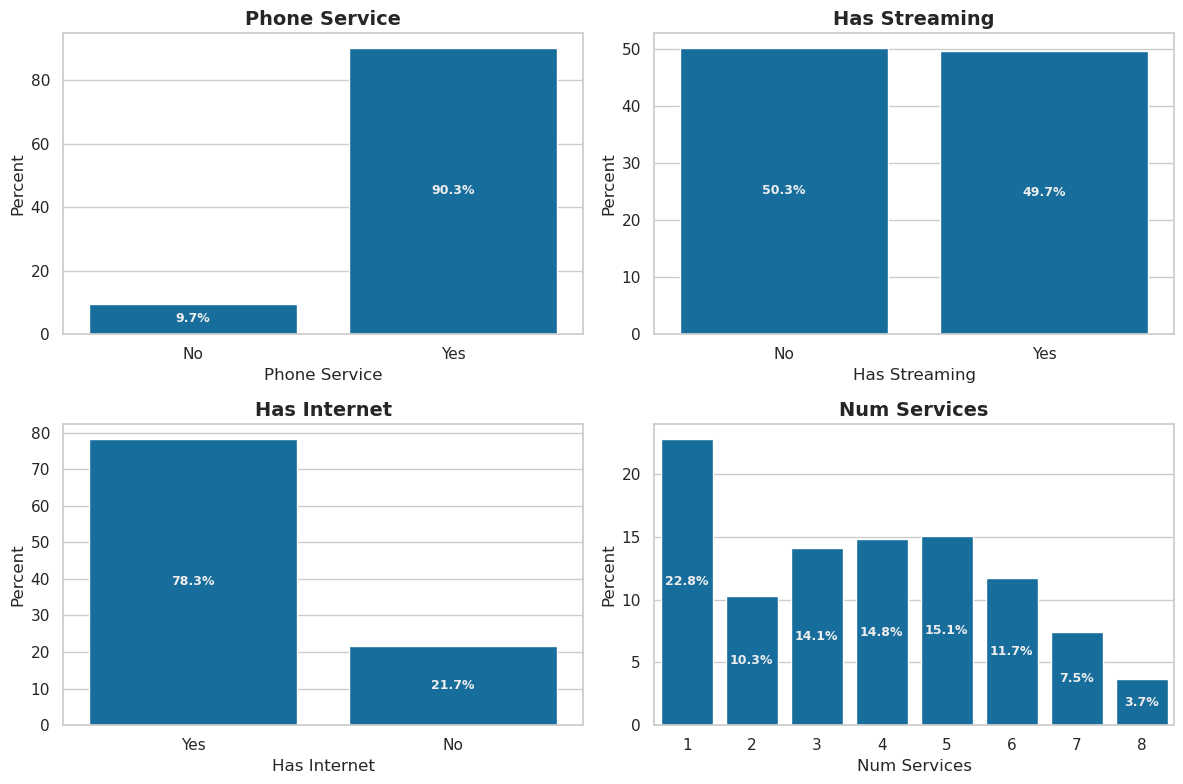

In [8]:

# Visualize key demographic features
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Create plots with helper function
styled_countplot(data=df_readable, x='phone_service', ax=axes[0, 0], stat='percent', label_type='center')
styled_countplot(data=df_readable, x='has_internet', ax=axes[1, 0], stat='percent', label_type='center')
styled_countplot(data=df_readable, x='has_streaming', ax=axes[0, 1], stat='percent', label_type='center')
styled_countplot(data=df_readable, x='num_services', ax=axes[1, 1], stat='percent', label_type='center')

plt.tight_layout()
plt.show()

**Observations:** Overall, most customers subscribe to multiple services, with near-universal adoption of phone and internet products.
The presence of streaming services appears moderately common, suggesting opportunities for cross-selling to single-service customers.

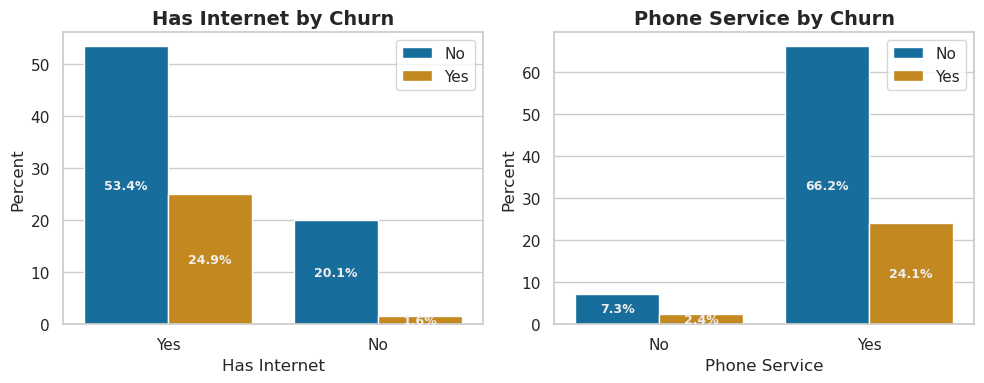

In [9]:
# Display service features by churn 
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

styled_countplot(data=df_readable, x='has_internet', ax=axes[0], hue='churn', stat='percent', label_type='center')
styled_countplot(data=df_readable, x='phone_service', ax=axes[1], hue='churn', stat='percent', label_type='center')

plt.tight_layout()
plt.show()

**Observations:**
- Customers with internet are more likely to churn when compared with customers using phone service; there may be internet services that are struggling with customer retention.
- I also examined multiple lines, which had no visible impact on customer retention.

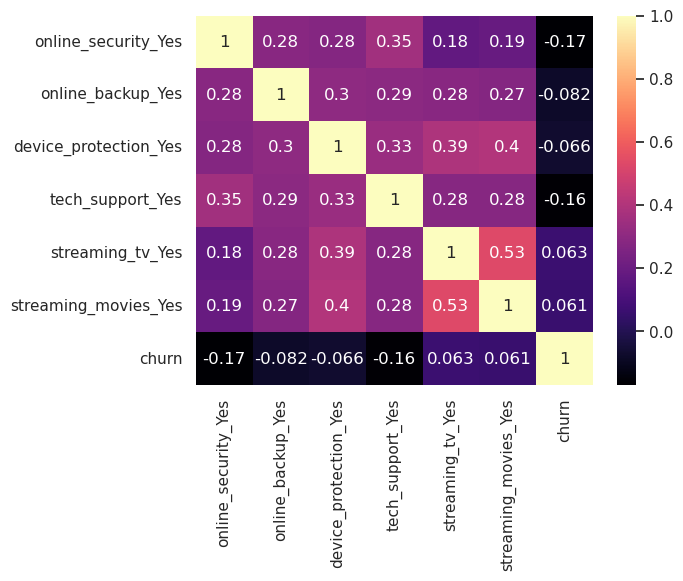

In [10]:
# Get list of internet services
internet_services = ['online_security_Yes', 'online_backup_Yes', 'device_protection_Yes', 'tech_support_Yes', 'streaming_tv_Yes', 'streaming_movies_Yes']

# Plot streaming service & churn correlations
plot = sns.heatmap(df[internet_services + ['churn']].corr(), annot=True, cmap='magma')
plt.show()

**Observations:** The streaming services are positively correlated with churn, suggesting that either the services themselves or perhaps thier cost is harming customer retention. Many customers seem to use both types of streaming services, whether by choice or due to service bundling options. Similarly, device protection and streaming are reasonably highly correlated, as well as tech support and online security. These will have to be accounted for in future modeling. Non-streaming internet services appear slightly negatively correlated with churn and may be useful in future retention improvement efforts.

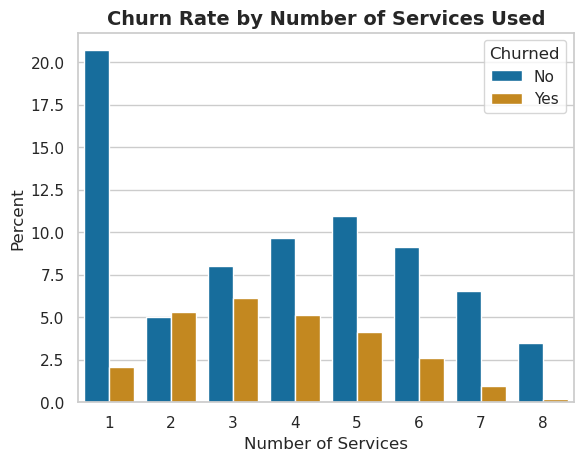

In [11]:
# Plot churn by total number of services used
styled_countplot(data=df_readable, x='num_services', hue='churn', stat='percent')
plt.xlabel('Number of Services')
plt.title('Churn Rate by Number of Services Used', fontsize=fontsize, fontweight=fontweight)
plt.legend(title='Churned')

plt.show()

**Observations:** Prior analysis has established the negarive and positive correlations between churn and different internet services, as well as phone service customers being less likely to churn. Customers with only one service are likely to be phone users, who have relatively low churn rates. Internet service was correlated with a higher churn rate, and would be the next service customers get.

**Interpretation:**
As internet services are added, churn amounts increase sharply in relation to total customers at that service level. This suggests that services like streaming TV and movies, which are positively correlated with churn, may be more common at levels 2 and 3. After peaking at 3, churn declines steadily as customers use more services, reinforcing the idea that multi-service customers are stickier and supporting the data showing negative correlations between most internet services and churn rate.

**Observations Summary:** 
- The majority of Telco customers use phone, internet, and roughly two-thirds use at least one other service; roughly half of customers have streaming. 

- Internet service users are more likely to churn than phone service users, and having multiple lines made no difference in churn rates.
- Streaming services were strongly correlated with churn, and while other services were only slightly negatively correlated with churn, customer retention is markedly improved for customers subscribed to online security and tech support.
- The churn rate is highest as a proportion of total customers at 2 services, falling gradually from there.

### 3.3 Account & Contract Features <a class="anchor" id="33-account--contract-features"></a>

Contract duration may indicate past satisfaction with Telco services, as satisfied customers may be more willing to enter long-term contracts. Similarly, automatic payment methods and paperless billing can change the perception of Telco services from a decision that is reviewed every billing period to a long-term decision. 

**Key Account & Contract Features:**
- contract
- payment_method
- paperless_billing

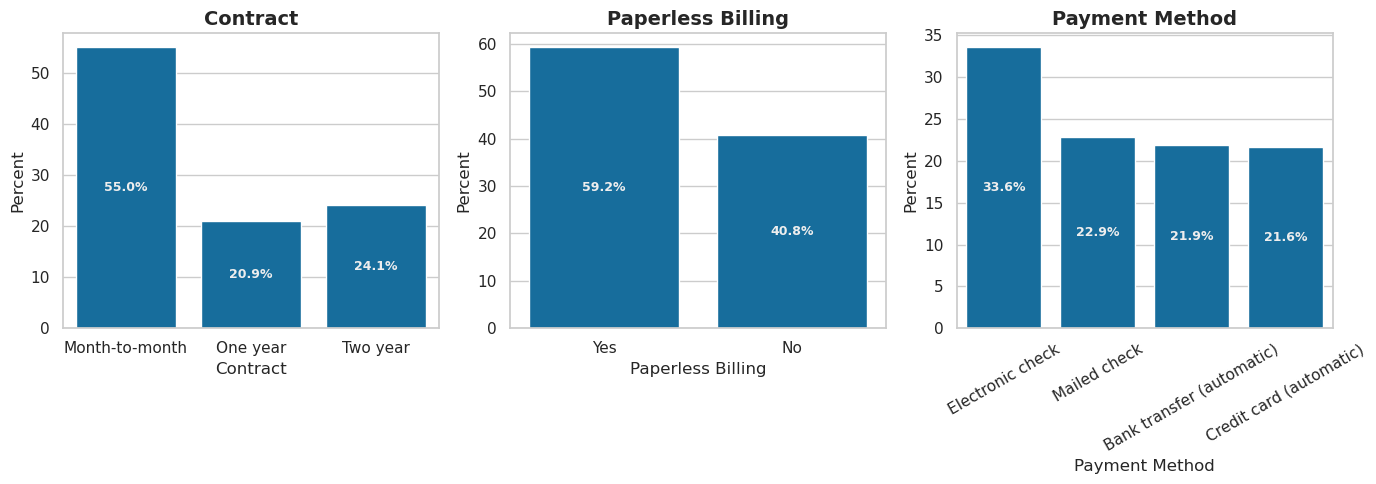

In [12]:
# Examine contract & account features
account_features = ['contract', 'paperless_billing', 'payment_method']

# Plot key account and contract features by churn rate
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

for ax, col in zip(axes, account_features):
    styled_countplot(data=df_readable, x=col,  ax=ax, stat='percent', label_type='center')
    plt.tick_params('x', rotation=30)
    
plt.tight_layout()
plt.show()

**Observations:** Most customers have month-to-month contracts and paperless billing. Electronic checks are the most favored payment method, but the other three types are close to being proportionally balanced. 

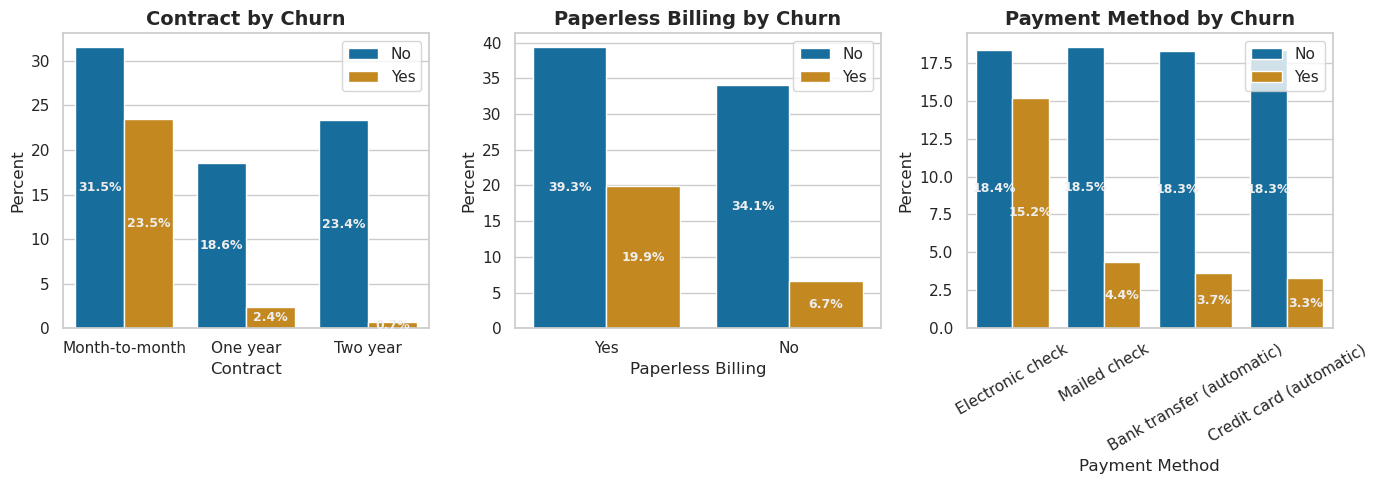

In [13]:
# Plot key account and contract features by churn rate
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

for ax, col in zip(axes, account_features):
    styled_countplot(data=df_readable, x=col,  ax=ax, stat='percent', hue='churn', label_type='center')
    plt.tick_params('x', rotation=30)
    
plt.tight_layout()
plt.show()

**Observations:** 
- Contract type appears to be closely linked to churn rate, with over a 2:3 ratio of customers in that group deciding not to renew their service contract.
- Customers with paperless billing were also significantly more likely to churn. This may indicate a quality of paperless billing associated with churn like the amount of customer engagement involved in the process, or it may be due to correlations with other factors like tech use.
- Payment using electronic check was the only payment method category markedly different regarding churn rate, and it makes sense that a non-automatic method would be associated with worse customer retention. 

In [14]:
# Check the proportion of overlap between different contract types and paperless billing 
pd.crosstab(df_readable['paperless_billing'], df_readable['contract'], 
                           values=df_readable['churn'], aggfunc=lambda x: (x == 'Yes').mean())

contract,Month-to-month,One year,Two year
paperless_billing,,,
No,0.314973,0.071322,0.016484
Yes,0.482985,0.147500,0.042038


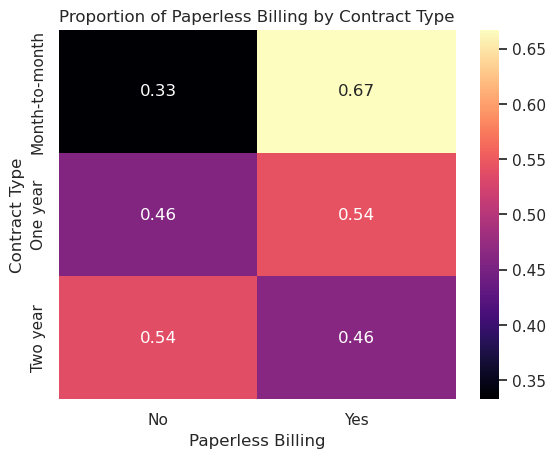

In [15]:
# Proportion of paperless billing for each contract type
paperless_by_contract = pd.crosstab(df_readable['contract'], df_readable['paperless_billing'], normalize='index')
sns.heatmap(paperless_by_contract, annot=True, cmap='magma', fmt='.2f', cbar=True)
plt.title('Proportion of Paperless Billing by Contract Type')
plt.ylabel('Contract Type')
plt.xlabel('Paperless Billing')
plt.show()

**Observations:** Month-to-month users seem to favor paperless billing at a rate markedly higher than other contract types. This may explain part of the correlation between paperless billing and lower customer retention.

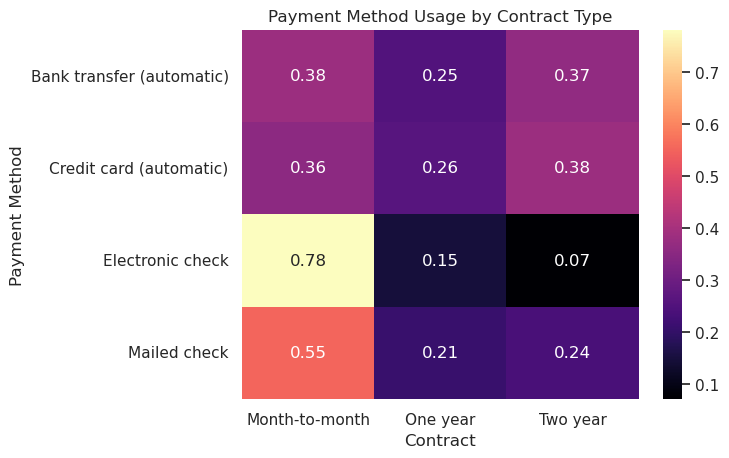

In [16]:
# Plot contract type and payment method proportions by the churn rate
heatmap_data = pd.crosstab(df_readable['payment_method'], df_readable['contract'], normalize='index')
sns.heatmap(heatmap_data, annot=True, cmap='magma', fmt='.2f')
plt.title('Payment Method Usage by Contract Type')
plt.xlabel('Contract')
plt.ylabel('Payment Method')

plt.show()


**Observations:** Checks, either electronic or mailed, are the most favored payment method for month-to-month customers. Electronic check had the highest churn rates among all payment methods, and customers with the combination of electronic check and month-to-month contracts had the highest churn rates among any pairing.

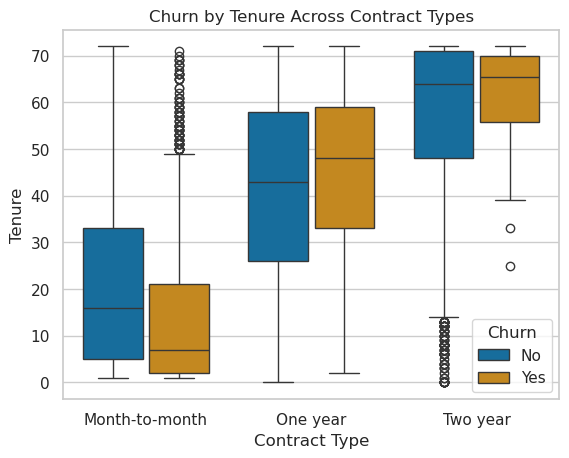

In [17]:
# Boxplot to show churn by tenure across contract types and paperless billing
sns.boxplot(data=df_readable, x='contract', y='tenure', hue='churn', gap=0.1)
plt.title('Churn by Tenure Across Contract Types')
plt.xlabel('Contract Type')
plt.ylabel('Tenure')
plt.legend(title='Churn')
plt.show()

**Observation:** Tenure and contract length are closely linked, as one would expect, but there are some meaningful outliers for month-to-month customers with long tenures. The largest difference in churn vs retained tenure is in the the month-to-month group, where over 75% of customers tend to churn before the 2-year mark.

**Observations Summary:**
- Month-to-month contract holders have the highest churn rates across all payment types.

- Electronic check users show the highest churn, while other payment methods were not signifcantly different.

- Paperless billing customers churn more often, possibly due to overlap with month-to-month plans or confounding factors.

- These findings suggest that contract length and payment type are strong churn predictors.

- Month-to-month customers tend to churn primarily in the first 2 years of their tenure, highlighting this period as a critical window for improving long-term customer retention. 

### 3.4 Financial Metrics <a class="anchor" id="34-financial-metrics"></a>

Customer spending often drives retention, as subscription costs directly influence the likelihood of churn. However, charges should not be considered in isolation, since factors such as service usage, contract type, and tenure also affect a customer’s perceived value.

**Key Demographic Features:**
- Monthly charges
- Monthly charge group
- Total charges
- Total charge group
- Average Monthly Charge


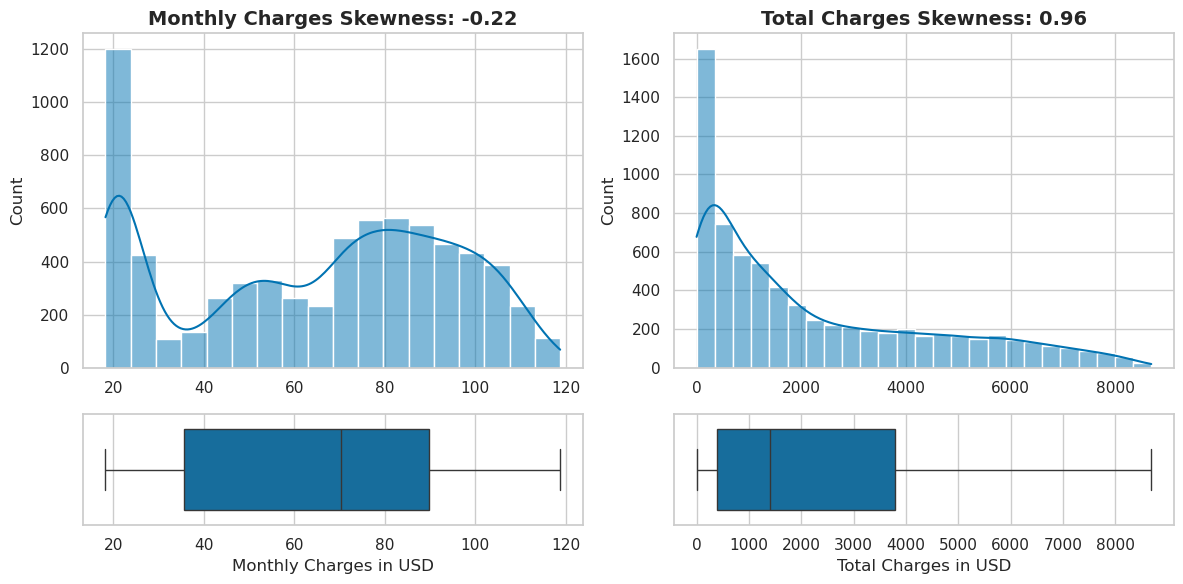

In [18]:
# Plot customer composition
fig, axes = plt.subplots(2, 2, figsize=(12, 6), gridspec_kw={'height_ratios': [3, 1]})

# Visualize montly charges distribution
sns.histplot(df_readable['monthly_charges'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title(
    # Display distribution skewness
    'Monthly Charges Skewness: ' + str(round(df_readable['monthly_charges'].skew(axis=0, skipna=True),2)), 
    fontweight=fontweight,
    fontsize=fontsize
    )
axes[0, 0].set_xlabel('')

# Visualize total charges distribution
sns.histplot(df_readable['total_charges'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title(
    # Display distribution skewness
    'Total Charges Skewness: ' + str(round(df_readable['total_charges'].skew(axis=0, skipna=True),2)), 
    fontweight=fontweight,
    fontsize=fontsize
    )
axes[0, 1].set_xlabel('')

# Visualize monthly charges outliers and IQR
sns.boxplot(df_readable, x='monthly_charges', orient='h', ax=axes[1, 0], gap=0.1)
axes[1, 0].set_xlabel('Monthly Charges in USD')

# Visualize total charges outliers and IQR
sns.boxplot(df_readable, x='total_charges', orient='h', ax=axes[1, 1], gap=0.1)
axes[1, 1].set_xlabel('Total Charges in USD')
axes[1, 1].set_xticks(np.arange(0, 9000, 1000))

plt.tight_layout()
plt.show()

**Observations:** The distributions show that most customers have relatively low monthly charges, while a smaller subset pays significantly more, causing the distribution to have a slight left skew. The monthly charges is reasonably right-skewed, reflecting the long tail of long-time or high-paying customers outnumbering customers have shorter tenures or lower monthly rates. The distinct breakpoints below $40, between $40–$70, and above $70 suggest possible service-tier or pricing thresholds.

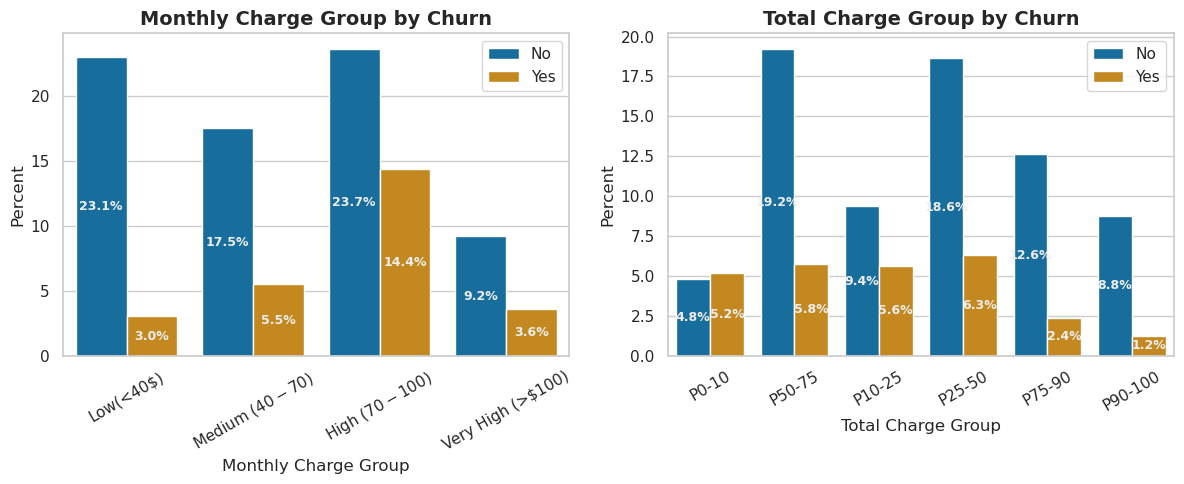

In [19]:
# Visualize grouped financial features distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

styled_countplot(df_readable, x='monthly_charge_group', hue='churn', ax=axes[0], stat='percent', label_type='center')
axes[0].tick_params('x', rotation=30) # Rotate x-ticks for better readibility

styled_countplot(df_readable, x='total_charge_group', hue='churn', ax=axes[1], stat='percent', label_type='center')
axes[1].tick_params('x', rotation=30) # Rotate x-ticks for better readibility

plt.tight_layout()
plt.show()

**Observations:** 

- **Monthly Charge Groups:** Churn generally increases with higher monthly charges, consistent with expectations. However, the Very High monthly charge group (> $100) shows a lower absolute churn rate (3.6%) compared with the High group (14.4%), even though it represents a smaller portion of the customer base (12.8% of the total range). When considered proportionally relative to group size, churn is still notable in the Very High group, which may reflect that these customers subscribe to premium services that help retain them.

- **Total Charge Groups:** Raw churn percentages across total charge groups are less variable, but examining churn relative to group size highlights meaningful patterns. Customers in the lowest decile (P0–10) are more likely to churn than stay, and even in the next decile (P10–25), churn accounts for over a third of the group. Beyond the 25th percentile, churn declines sharply and retention dominates, indicating that higher total charges - likely reflecting longer tenure - are associated with improved retention.

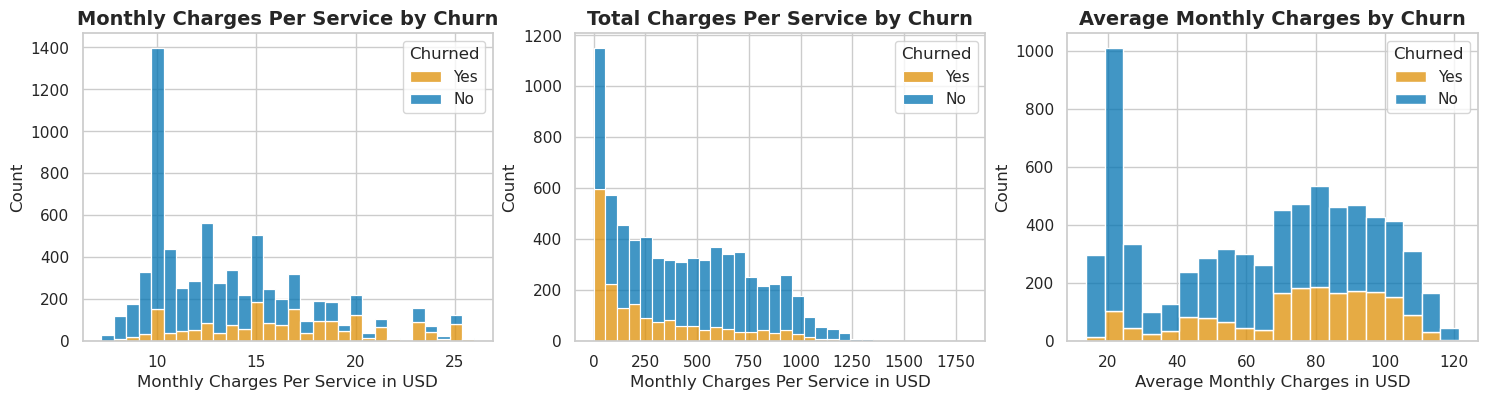

In [20]:
# Plot monthly and total charges per service and average monthly charges
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

sns.histplot(df, x='monthly_charges_per_service', hue='churn',multiple='stack', ax=axes[0])
axes[0].set_title('Monthly Charges Per Service by Churn', fontsize=fontsize, fontweight=fontweight)
axes[0].set_xlabel('Monthly Charges Per Service in USD')
axes[0].legend(('Yes', 'No'), title='Churned')

sns.histplot(df, x='total_charges_per_service', hue='churn',multiple='stack', ax=axes[1])
axes[1].set_title('Total Charges Per Service by Churn', fontsize=fontsize, fontweight=fontweight)
axes[1].set_xlabel('Monthly Charges Per Service in USD')
axes[1].legend(('Yes', 'No'), title='Churned')

sns.histplot(df, x='avg_monthly_charges', hue='churn',multiple='stack', ax=axes[2])
axes[2].set_title('Average Monthly Charges by Churn', fontsize=fontsize, fontweight=fontweight)
axes[2].set_xlabel('Average Monthly Charges in USD')
axes[2].legend(('Yes', 'No'), title='Churned')

plt.show()

**Observations:** 

- **Monthly Charges per Service:** As the monthly cost per service increases, the churn rate generally rises, though not uniformly. A notable breakpoint appears around $15 per service, beyond which churn becomes increasingly common. While customers with more internet services often show higher retention, the pattern here suggests that higher-priced service bundles may be contributing to churn among certain segments.

- **Total Charges per Service:**
Churn patterns relative to total charges per service largely mirror earlier trends tied to tenure and contract type - customers with lower total spending (typically newer customers) exhibit a higher likelihood of churn. 

- **Average Monthly Charges:** The average monthly charges show how closely charges and churn are related. Customer retention is strained between $70 and $100 average monthly charges. There is a second, smaller spike in proportional churn rate around $30 to $45 which is worth examining, but generally speaking, lower average monthly charges mean better customer retention. 

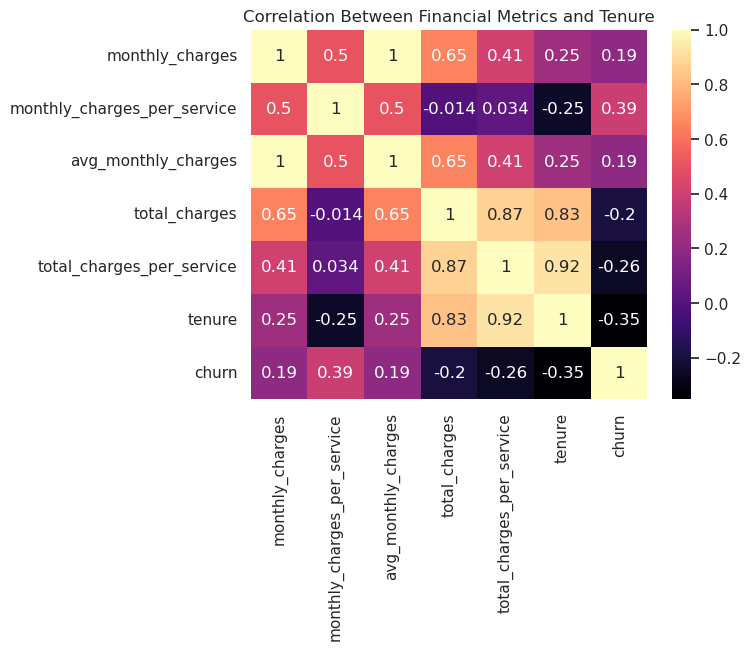

In [21]:
# Plot correlation heatmap
corr = df[['monthly_charges', 'monthly_charges_per_service', 'avg_monthly_charges', 'total_charges', 'total_charges_per_service', 'tenure', 'churn']].corr()
sns.heatmap(corr, annot=True, cmap='magma')
plt.title('Correlation Between Financial Metrics and Tenure')
plt.show()

**Observation:** As shown later in the correlation heatmap, `total_charges` and `tenure` exhibit a strong positive relationship, confirming that longer customer relationships naturally result in higher accumulated charges. There are also expected strong correlations between the charge features and their per-service counterparts. The highest correlation with churn is monthly charges, although tenure has a reasonably strong negative correlation with churn. This chart also confirms expected correlations with features like `monthly_charges` and `avg_monthly_charges`. 


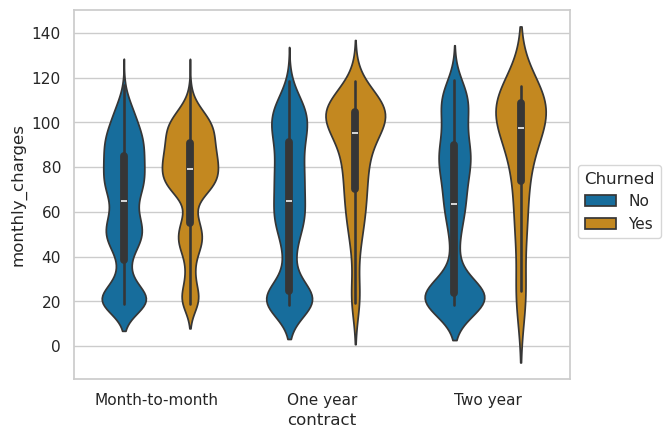

In [22]:
# Plot monthly charges and contract type colored by churn
sns.violinplot(data=df_readable, x='contract', y='monthly_charges', hue='churn', gap=0.1)
plt.legend(bbox_to_anchor=(1.0, 0.6), title='Churned') # Position legend outside of plot
plt.show()

**Observations:**
- Customers on Two year contracts show the widest range of monthly charges, including many high-paying customers.  
- Month-to-month contracts have a narrower distribution, generally lower monthly charges, with a few high outliers.  
- Across all contract types, churn is disproportionately higher among Month-to-Month customers, but monthly charges seems to have greater influence on long-term contracts (One-year, Two-year).  
- Long-term contracts are associated with lower churn, suggesting loyalty or pricing incentives play a role.

**Interpretation:**  
The distribution patterns suggest that contract type strongly influences both monthly charges and churn behavior. Higher variability and higher monthly charges in Month-to-Month plans may reflect flexibility or premium service options, but these customers are also more likely to churn. In contrast, long-term contracts appear to stabilize monthly revenue and promote retention, highlighting the value of contract incentives in reducing churn.

**Summary:**

- New customers have much higher churn rates than long-term customers.
- Higher monthly charges and monthly charges per service are both correlated with worse customer retention.
- Customers with higher tenure churn at much lower rates, but are still sensitive to higher charge rates. 
- Long-term contracts and greater retention are closely related, but high monthly charges still harm customer retention.

### 3.5 Tenure & Loyalty Feature Synthesis <a class="anchor" id="35-tenure--loyalty-feature-synthesis"></a>

Customer loyalty is built over time, generating goodwill through a positive product-service experience at each pricepoint. From that angle, tenure can be viewed as being related to customer satisfaction. We have already observed that tenure is closely related to churn, contract type, and total charges, so this section will extend that by focusing on derived loyalty indicators to better understand customer retention patterns. 

**Key Tenure & Loyalty Features:**
- tenure
- tenure_group

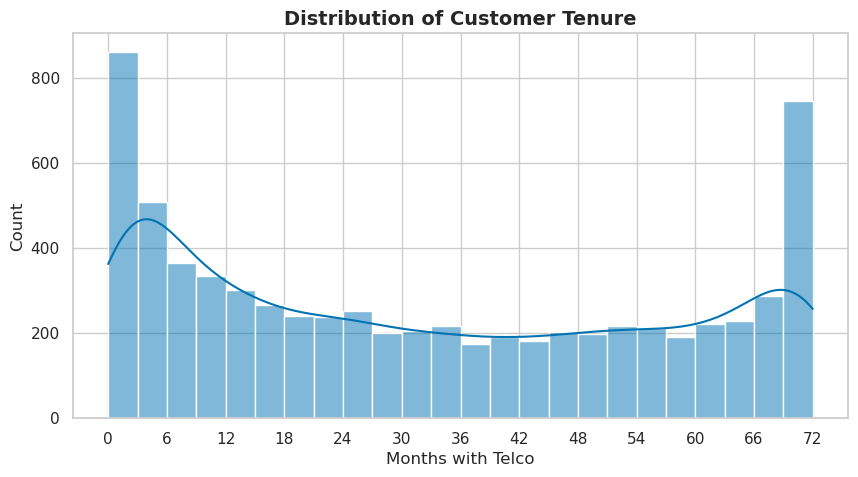

In [23]:
# Visualize tenure by churn
fig, axes = plt.subplots(1, 1, figsize=(10, 5))

# Visualize tenure distribution
sns.histplot(data=df, x='tenure', kde=True, bins=24, ax=axes) # Set bin size to be roughly 3-months
axes.set_title('Distribution of Customer Tenure', fontsize=fontsize, fontweight=fontweight)
axes.set_xlabel('Months with Telco')
axes.set_ylabel('Count')
axes.set_xticks(np.arange(0, 73, 6))

plt.show()

**Observations:** Customer tenure is noticeably concentrated at either end of the distribution, with a declining peak of short-tenure customers and a sharp spike of long-term customers. Customer tenure counts markedly fall within the first 18 months, with a continuing but more gradual decline after that. If this is a persistent pattern and not a sudden spike in new customers, it suggests that the first year is particularly important for customer retention. 

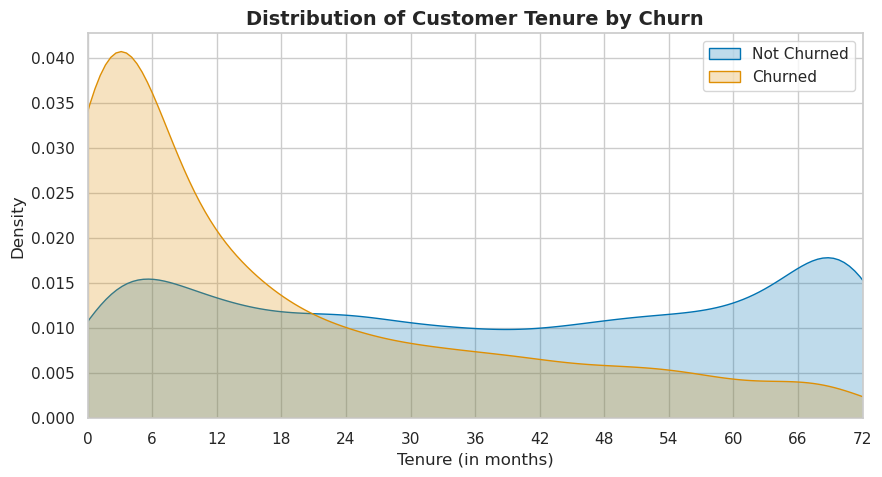

In [24]:
# Visualie distinct tenure groups by churn
fig, axes = plt.subplots(figsize=(10, 5))
sns.kdeplot(data=df[df['churn'] == 0]['tenure'], label='Not Churned', fill=True, common_norm=False)
sns.kdeplot(data=df[df['churn'] == 1]['tenure'], label='Churned', fill=True, common_norm=False)
axes.set_title('Distribution of Customer Tenure by Churn', fontsize=fontsize, fontweight=fontweight)
axes.set_xlabel('Tenure (in months)')
axes.set_xticks(np.arange(0, 73, 6))
axes.set_xlim(0, 72)
axes.legend()

plt.show()

**Observations:** The churn rate is highest in the first half-year. Although it falls rather sharply over the following 12 months, this 18-month period represents the highest concentration of churned customers. The distributions cross at around the 22-month mark, when customer retention finally overtakes churn.   

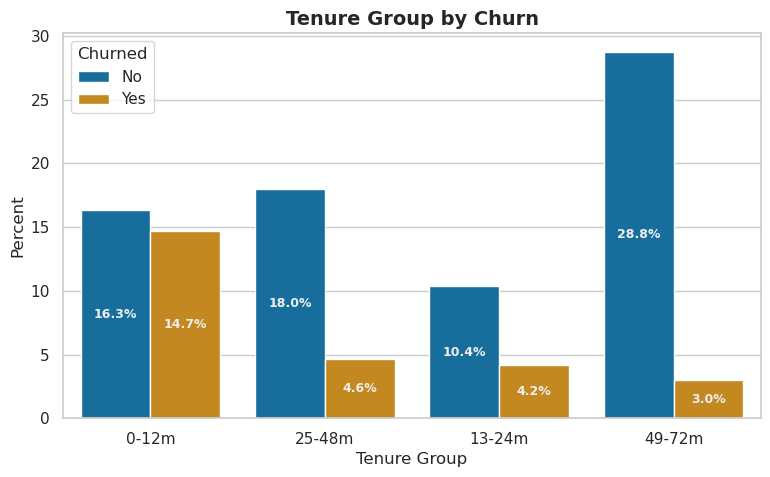

In [25]:
plt.figure(figsize=(9, 5))
styled_countplot(df_readable, x='tenure_group', hue='churn', stat='percent', label_type='center')
plt.legend(title='Churned')

plt.show()

**Customer Lifecycle Observations:**

- The tenure distribution suggests a large influx of short-term customers who leave within the first year, followed by a smaller but more stable base of long-term subscribers.

- Churn is most pronounced in the first 18 months, highlighting an early retention challenge. After roughly two years, customers who remain tend to stay.
- Long-term customers generally pay higher monthly charges, but retention is more strongly associated with tenure itself than with spending level.
- These trends emphasize the importance of **early-stage retention programs** and potentially **graduated loyalty incentives** to move new customers past the high-risk 12–18-month window.


---

## 3.6 Summary <a class="anchor" id="36-summary"></a>

This notebook explored the Telco Churn dataset to uncover patterns and relationships that influence customer churn. We examined demographic, service, account, contract, and financial features, identifying how each relates to churn likelihood. Key observations include higher churn among senior citizens, customers without partners or dependents, and those on month-to-month contracts or using paperless billing. Service usage analysis revealed that customers with multiple services tend to be more loyal, while higher monthly charges and certain internet or streaming services are associated with increased churn. Tenure emerged as a critical factor, with the first 12–18 months representing a high-risk period for churn, followed by stabilization among long-term
